In [172]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
from sklearn.cross_validation import cross_val_score, train_test_split, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.grid_search import GridSearchCV
from geopy.distance import great_circle
from sklearn.feature_selection import RFECV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import scale

In [4]:
train = pd.read_csv('/Users/teresaborcuch/Chicago-Mosquito-Study/datasets/train_clean.csv')
test = pd.read_csv('/Users/teresaborcuch/Chicago-Mosquito-Study/datasets/test_clean.csv')

In [8]:
del train['Unnamed: 0']

In [12]:
del test['Unnamed: 0']

In [10]:
train.shape

(10506, 15)

In [17]:
test.head()

,Latitude,Longitude,PavgW,TmaxW,Species_CULEX ERRATICUS,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS
0,41.95469,-87.800991,0.101429,82.428571,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,41.95469,-87.800991,0.101429,82.428571,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,41.95469,-87.800991,0.101429,82.428571,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,41.95469,-87.800991,0.101429,82.428571,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,41.95469,-87.800991,0.101429,82.428571,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [15]:
train.head()

,Trap,Date,Latitude,Longitude,NumMosquitos,PavgW,TmaxW,WnvPresent,Species_CULEX ERRATICUS,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS
0,T002,2007-05-29,41.954690,-87.800991,1,0.035714,82.285714,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,T002,2007-05-29,41.954690,-87.800991,1,0.035714,82.285714,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,T007,2007-05-29,41.994991,-87.769279,1,0.035714,82.285714,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,T015,2007-05-29,41.974089,-87.824812,1,0.035714,82.285714,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,T015,2007-05-29,41.974089,-87.824812,4,0.035714,82.285714,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [156]:
max(train['Date'])

'2013-09-26'

In [18]:
train_select = train[[u'Latitude', u'Longitude', u'PavgW',
       u'TmaxW', u'Species_CULEX ERRATICUS',
       u'Species_CULEX PIPIENS', u'Species_CULEX PIPIENS/RESTUANS',
       u'Species_CULEX RESTUANS', u'Species_CULEX SALINARIUS',
       u'Species_CULEX TARSALIS', u'Species_CULEX TERRITANS']]

# Get Shoreline Data

In [77]:
lat_list = [42.063793,42.015808,42.024367,42.000831,42.000831,42.000831,41.885042,41.833249,41.799427,41.752367]
lon_list = [-87.673804,-87.661582,-87.665163,-87.655729,-87.655729,-87.655729,-87.612685,-87.604038,-87.579724,-87.542049]
 
coastline_lat_lon = pd.DataFrame(columns=["Latitude","Longitude"])
coastline_lat_lon["Latitude"]=lat_list
coastline_lat_lon["Longitude"]=lon_list
coastline_lat_lon

,Latitude,Longitude
0,42.063793,-87.673804
1,42.015808,-87.661582
2,42.024367,-87.665163
3,42.000831,-87.655729
4,42.000831,-87.655729
5,42.000831,-87.655729
6,41.885042,-87.612685
7,41.833249,-87.604038
8,41.799427,-87.579724
9,41.752367,-87.542049


In [78]:
def find_closest_shoreline_from_trap(trap_lat,trap_lon,coastline_lat_lon):
    distance_list = []
    for i  in coastline_lat_lon.iterrows():
        coastline_longitude = i[1][1]
        coastline_latitude = i[1][0]
        coastline_coord = (coastline_latitude,coastline_longitude)
        trap_coord = (trap_lat,trap_lon)
        distance_list.append(great_circle(trap_coord,coastline_coord).meters)
    return(min(distance_list))

In [81]:
# get shoreline data for train
trap_shoreline_distance_list = []
for i, row in train_select.iterrows():
    dist = find_closest_shoreline_from_trap(row[0], row[1], coastline_lat_lon)
    trap_shoreline_distance_list.append(dist)

train_select['shoreline_dist'] = trap_shoreline_distance_list

/Users/teresaborcuch/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [140]:
test.head(1)

,Latitude,Longitude,PavgW,TmaxW,Species_CULEX ERRATICUS,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS,shoreline_dist
0,41.95469,-87.800991,0.101429,82.428571,0.0,0.0,1.0,0.0,0.0,0.0,0.0,13061.621983


In [139]:
# get shoreline data for test
trap_shoreline_distance_list = []
for i, row in test.iterrows():
    dist = find_closest_shoreline_from_trap(row[0], row[1], coastline_lat_lon)
    trap_shoreline_distance_list.append(dist)

test['shoreline_dist'] = trap_shoreline_distance_list

# EDA

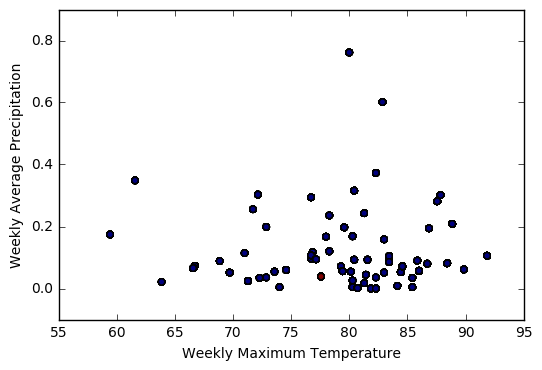

In [160]:
plt.scatter(train['TmaxW'], train['PavgW'], c= train['WnvPresent'])
plt.xlabel('Weekly Maximum Temperature')
plt.ylabel('Weekly Average Precipitation')
plt.show()

# Train and Test Sets

In [222]:
# normalize data
train_norm = pd.DataFrame(scale(train_select), columns = [u'Latitude', u'Longitude', u'PavgW', u'TmaxW',
       u'Species_CULEX ERRATICUS', u'Species_CULEX PIPIENS',
       u'Species_CULEX PIPIENS/RESTUANS', u'Species_CULEX RESTUANS',
       u'Species_CULEX SALINARIUS', u'Species_CULEX TARSALIS',
       u'Species_CULEX TERRITANS', u'shoreline_dist'])

In [221]:
train_select.columns

Index([u'Latitude', u'Longitude', u'PavgW', u'TmaxW',
       u'Species_CULEX ERRATICUS', u'Species_CULEX PIPIENS',
       u'Species_CULEX PIPIENS/RESTUANS', u'Species_CULEX RESTUANS',
       u'Species_CULEX SALINARIUS', u'Species_CULEX TARSALIS',
       u'Species_CULEX TERRITANS', u'shoreline_dist'],
      dtype='object')

In [174]:
y = train.WnvPresent

In [175]:
y.value_counts()

0    9955
1     551
Name: WnvPresent, dtype: int64

In [176]:
551.0/(551+9955)

0.05244622120692937

In [177]:
# make train and test sets
X_train, X_test, y_train, y_test = train_test_split(train_select, y, test_size = 0.3)

# Fit All the Models

In [207]:
def fit_and_score(model, name):
    model.fit(X_train, y_train)
    accuracy = cross_val_score(dt, X_test, y_test, cv = 10, scoring = 'accuracy')
    model_scores[name] = np.mean(accuracy)
    predictions = model.predict(X_test)
    conmat = pd.DataFrame(confusion_matrix(y_test, predictions), columns=['Wnv Not Present', 'Wnv Present'], index = ['Wnv Not Present', 'Wnv Present'])
    
    print conmat

In [208]:
# create dictionary to hold scores
model_scores = {}

In [209]:
# decision tree
dt = DecisionTreeClassifier()
fit_and_score(dt, 'Decision Tree')

                 Wnv Not Present  Wnv Present
Wnv Not Present             2891          101
Wnv Present                  133           27


In [210]:
# bagging tree
bt = BaggingClassifier()
fit_and_score(bt, 'Bagging Classifier')

                 Wnv Not Present  Wnv Present
Wnv Not Present             2961           31
Wnv Present                  144           16


In [211]:
# gradient boosting classifier
gbc = GradientBoostingClassifier()
fit_and_score(gbc, 'Gradient Boosting')

                 Wnv Not Present  Wnv Present
Wnv Not Present             2992            0
Wnv Present                  159            1


In [212]:
# gridsearch for gradient boosting classifier
params = {'n_estimators': [5,10,25,100,200,500],
          'loss': ['deviance','exponential'],
          'max_depth': [None, 3, 5, 10],
          'max_features': [0.25,0.5,0.75,1.0]}

gsgbc = GridSearchCV(GradientBoostingClassifier(),
                    params, n_jobs=-1,
                    cv=KFold(len(y_train), n_folds=3, shuffle=True),
                   scoring = 'accuracy')
fit_and_score(gsgbc, 'GS Gradient Boost')

                 Wnv Not Present  Wnv Present
Wnv Not Present             2992            0
Wnv Present                  160            0


In [213]:
# adaboost 
adb = AdaBoostClassifier()
fit_and_score(adb, 'AdaBoost')

                 Wnv Not Present  Wnv Present
Wnv Not Present             2992            0
Wnv Present                  160            0


In [214]:
# gridsearch adaboost
params = {'n_estimators': [5,10,25,100,200,500],
          'learning_rate': [0.25,0.5,0.75,1.0]}

gsab = GridSearchCV(AdaBoostClassifier(),
                    params, n_jobs=-1,
                    cv=KFold(len(y_train), n_folds=3, shuffle=True),
                   scoring = 'accuracy')
fit_and_score(gsab, "GS Adaboost")

                 Wnv Not Present  Wnv Present
Wnv Not Present             2992            0
Wnv Present                  160            0


In [215]:
# random forest
rf = RandomForestClassifier()
fit_and_score(rf, 'Random Forest')

                 Wnv Not Present  Wnv Present
Wnv Not Present             2968           24
Wnv Present                  146           14


In [216]:
# gridsearch random forests
params = {'n_estimators': [5,10,25,100,200,500],
          'min_samples_split': [2, 5],
          'min_samples_leaf': [1, 2, 3],
          'bootstrap': [True, False]}

gsrf = GridSearchCV(RandomForestClassifier(),
                    params, n_jobs=-1,
                    cv=KFold(len(y_train), n_folds=3, shuffle=True),
                   scoring = 'accuracy')
fit_and_score(gsrf, "GS Random Forest")

                 Wnv Not Present  Wnv Present
Wnv Not Present             2989            3
Wnv Present                  155            5


In [217]:
# Extra Trees
et = ExtraTreesClassifier()
fit_and_score(et, "Extra Trees")

                 Wnv Not Present  Wnv Present
Wnv Not Present             2959           33
Wnv Present                  145           15


In [218]:
model_scores

{'AdaBoost': 0.91497387984729761,
 'Bagging Classifier': 0.91529033554350003,
 'Decision Tree': 0.91592626079967854,
 'Extra Trees': 0.91370504319871415,
 'GS Adaboost': 0.91687864175205946,
 'GS Gradient Boost': 0.91338858750251151,
 'GS Random Forest': 0.91307112718505112,
 'Gradient Boosting': 0.91338758288125388,
 'Random Forest': 0.91528732167972682}

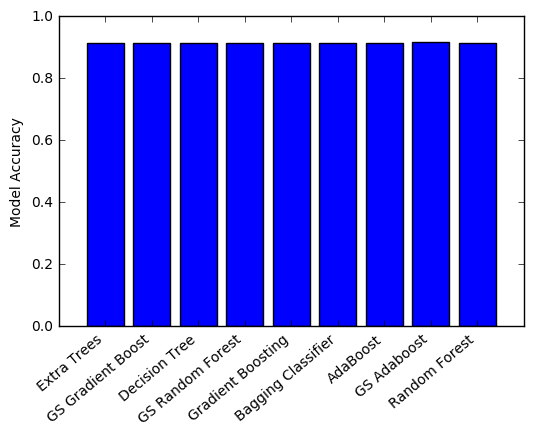

In [219]:
h = plt.bar(range(len(model_scores)), model_scores.values(), align='center')
xticks_pos = [0.55*patch.get_width() + patch.get_xy()[0] for patch in h]
plt.xticks(range(len(model_scores)), model_scores.keys(), rotation = 40, ha = 'right')
plt.ylabel('Model Accuracy')
plt.show()

These models all have around the same accuracy, and based on previous two submissions (LogisticRegressionCV and a Random Forest both got 0.500 on Kaggle...must try feature selection).

# Feature Selection

I'll try it for the Gradient Boosting Classifier.

In [242]:
# RFECV feature selection
rfecv = RFECV(estimator = GradientBoostingClassifier(), cv = 5, scoring = 'recall')
rfecv.fit(train_select,y)
rfecv_cols = train_norm.columns[rfecv.support_]

In [243]:
rfecv_cols

Index([u'Longitude', u'PavgW', u'TmaxW'], dtype='object')

In [244]:
X = train_select[[u'Latitude', u'Longitude', u'PavgW', u'TmaxW', u'shoreline_dist']]

In [245]:
# make train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [246]:
rfecv_scores = {}

In [247]:
def fit_and_score(model, name):
    model.fit(X_train, y_train)
    accuracy = cross_val_score(dt, X_test, y_test, cv = 10, scoring = 'recall')
    rfecv_scores[name] = np.mean(accuracy)
    predictions = model.predict(X_test)
    conmat = pd.DataFrame(confusion_matrix(y_test, predictions), columns=['Wnv Not Present', 'Wnv Present'])
    print conmat

In [248]:
# decision tree
dt = DecisionTreeClassifier()
fit_and_score(dt, 'Decision Tree')

   Wnv Not Present  Wnv Present
0             2951           51
1              131           19


In [249]:
# bagging tree
bt = BaggingClassifier()
fit_and_score(bt, 'Bagging Classifier')

   Wnv Not Present  Wnv Present
0             2954           48
1              131           19


In [250]:
# gradient boosting classifier
gbc = GradientBoostingClassifier()
fit_and_score(gbc, 'Gradient Boosting')

   Wnv Not Present  Wnv Present
0             3001            1
1              148            2


In [251]:
# gridsearch for gradient boosting classifier
params = {'n_estimators': [5,10,25,100,200,500],
          'loss': ['deviance','exponential'],
          'max_depth': [None, 3, 5, 10],
          'max_features': [0.25,0.5,0.75,1.0]}

gsgbc = GridSearchCV(GradientBoostingClassifier(),
                    params, n_jobs=-1,
                    cv=KFold(len(y_train), n_folds=3, shuffle=True),
                   scoring = 'accuracy')
fit_and_score(gsgbc, 'GS Gradient Boost')

   Wnv Not Present  Wnv Present
0             3002            0
1              150            0


In [252]:
# adaboost 
adb = AdaBoostClassifier()
fit_and_score(adb, 'AdaBoost')

   Wnv Not Present  Wnv Present
0             3002            0
1              150            0


In [253]:
# gridsearch adaboost
params = {'n_estimators': [5,10,25,100,200,500],
          'learning_rate': [0.25,0.5,0.75,1.0]}

gsab = GridSearchCV(AdaBoostClassifier(),
                    params, n_jobs=-1,
                    cv=KFold(len(y_train), n_folds=3, shuffle=True),
                   scoring = 'accuracy')
fit_and_score(gsab, "GS Adaboost")

   Wnv Not Present  Wnv Present
0             3002            0
1              150            0


In [254]:
# random forest
rf = RandomForestClassifier()
fit_and_score(rf, 'Random Forest')

   Wnv Not Present  Wnv Present
0             2951           51
1              127           23


In [255]:
# gridsearch random forests
params = {'n_estimators': [5,10,25,100,200,500],
          'min_samples_split': [2, 5],
          'min_samples_leaf': [1, 2, 3],
          'bootstrap': [True, False]}

gsrf = GridSearchCV(RandomForestClassifier(),
                    params, n_jobs=-1,
                    cv=KFold(len(y_train), n_folds=3, shuffle=True),
                   scoring = 'accuracy')
fit_and_score(gsrf, "GS Random Forest")

   Wnv Not Present  Wnv Present
0             2994            8
1              145            5


In [256]:
# Extra Trees
et = ExtraTreesClassifier()
fit_and_score(et, "Extra Trees")

   Wnv Not Present  Wnv Present
0             2963           39
1              134           16


In [257]:
rfecv_scores

{'AdaBoost': 0.11333333333333333,
 'Bagging Classifier': 0.08666666666666667,
 'Decision Tree': 0.10000000000000001,
 'Extra Trees': 0.10000000000000001,
 'GS Adaboost': 0.10000000000000001,
 'GS Gradient Boost': 0.10000000000000001,
 'GS Random Forest': 0.10000000000000001,
 'Gradient Boosting': 0.10666666666666666,
 'Random Forest': 0.093333333333333338}

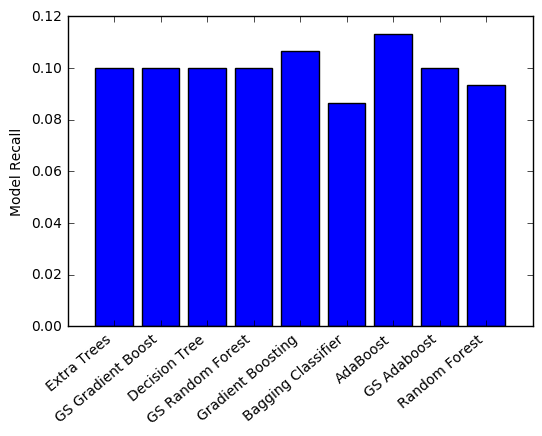

In [259]:
h = plt.bar(range(len(rfecv_scores)), rfecv_scores.values(), align='center')
xticks_pos = [0.55*patch.get_width() + patch.get_xy()[0] for patch in h]
plt.xticks(range(len(rfecv_scores)), rfecv_scores.keys(), rotation = 40, ha = 'right')
plt.ylabel('Model Recall')
plt.show()

Adaboost is the best model, so submit to Kaggle.

In [261]:
# train the gsgcb on full data
adb.fit(X,y)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [262]:
# select columns from test data
rfecv_test = test[[u'Latitude', u'Longitude', u'PavgW', u'TmaxW', u'shoreline_dist']]

In [264]:
rfecv_test_norm =scale(rfecv_test)

In [263]:
adb

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [265]:
predictions = adb.predict(rfecv_test)

In [266]:
len(predictions)

116293

In [267]:
submission = pd.DataFrame(columns = ['Id','WnvPresent'])
submission['Id'] = range(1, 116294)
submission['WnvPresent'] = predictions

In [268]:
submission['WnvPresent'].value_counts()

0    116293
Name: WnvPresent, dtype: int64

In [269]:
submission.to_csv('/Users/teresaborcuch/Chicago-Mosquito-Study/adb_submission.csv')